In [1]:
###################################################################################################
#
# Copyright (C) 2022 Maxim Integrated Products, Inc. All Rights Reserved.
#
# Maxim Integrated Products, Inc. Default Copyright Notice:
# https://www.maximintegrated.com/en/aboutus/legal/copyrights.html
#
###################################################################################################

## IMPORTS
import os
import sys
import datetime
import time

import importlib
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from pathlib import Path
from collections import OrderedDict

import distiller

## FOR TENSOR BOARD
try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

## PATH FOR MODELS AND DATASET
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'models'))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'datasets'))

from unetnilm.metrics import get_results_summary, example_f1_score
from datasets import nilm
import ai8x
mod = importlib.import_module("ai87net-unetnilm")

%matplotlib inline

msglogger = None

## Variable Declarations

In [2]:
dataset_fn = nilm.ukdale_get_datasets
data_path = "../data/NILM/"
batch_size = 8
workers = 5
validation_split = 0.1
deterministic = True
dataset_name = "ukdale"
appliance_data = {
    "kettle": {
        "mean": 700,
        "std": 1000,
        'window':10,
        'on_power_threshold': 2000,
        'max_on_power': 3998
    },
    "fridge": {
        "mean": 200,
        "std": 400,
        "window":50,
        'on_power_threshold': 50,
    },
    "dish washer": {
        "mean": 700,
        "std": 700,
        "window":50,
        'on_power_threshold': 10
    },
    "washer dryer": {
        "mean": 400,
        "std": 700,
        "window":50,
        'on_power_threshold': 20,
        'max_on_power': 3999
    },
    "microwave": {
        "mean": 500,
        "std": 800,
        "window":10,
        'on_power_threshold': 200,
    },
}
appliances = list(appliance_data.keys())

## Variable Declaration for MSG Logger
log_prefix = "ukdale-train"
log_dir = "../logs/"
dataset_name = "ukdale"
num_classes = 5
model_name = "cnn1dnilm"
seq_len = 100
lr = 1e-4

## Variable Declaration for Model
quantiles = [0.0025,0.1, 0.5, 0.9, 0.975]

## Helper Functions

In [3]:
class Args:
        def __init__(self, act_mode_8bit):
                self.act_mode_8bit = act_mode_8bit
                self.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

class NormDen:
        def __init__(self, mini, maxi):
               self.mini = mini
               self.maxi = maxi

        def normalize(self, data):
                data = (data - self.mini) / (self.maxi - self.mini)
                return data.sub(0.5).mul(256.).round().clamp(min=-128, max=127).div(128.)

## MSG Logger

In [4]:
msglogger = apputils.config_pylogger('logging.conf', log_prefix,
                                        log_dir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+dataset_name)

tflogger.tblogger.writer.add_text('Command line', "args ---")

msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\seq_len=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f',
                dataset_name,dataset_fn,num_classes,model_name,seq_len,batch_size,validation_split,lr)

Log file for this run: C:\Users\MTinaco\Dev\ai8x-training\logs\ukdale-train___2024.02.22-011139\ukdale-train___2024.02.22-011139.log



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



dataset_name:ukdale
dataset_fn=<function ukdale_get_datasets at 0x0000019D71AE31F0>
num_classes=5
model_name=cnn1dnilm\seq_len=100
batch_size=8
validation_split=0.1
lr=0.000100


## Dataset Loading

In [5]:
args = Args(act_mode_8bit=False)
train_set, test_set, val_set = dataset_fn((data_path, args), load_train=True, load_test=True, load_val=True)
train_set.visualize_batch()

0


In [6]:
train_loader, val_loader, test_loader, _ = apputils.get_data_loaders(
        dataset_fn, (data_path,args), batch_size,
        workers, validation_split, deterministic,1, 1, 1)
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d',
                   len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)

Dataset sizes:
	training=582237
	validation=64692
	test=161658
Augmentations:Compose(
)


## Model Loading

In [7]:
## Path Initialization
pth_path = '../logs/ukdale-train___2024.02.20-031228_golden/'
pth_best = os.path.join(os.path.dirname(pth_path), 'cnn1dnilm_best.pth.tar')
pth_checkpoint = os.path.join(os.path.dirname(pth_path), 'cnn1dnilm_checkpoint.pth.tar')

## Class for Args
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

args = Args(act_mode_8bit=False)


In [8]:
## device setup
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

ai8x.set_device(device=85, simulate=False, round_avg=False)

Running on device: cuda:0
Configuring device: MAX78000, simulate=False.


In [9]:
import torch
import torch.nn.functional as F
from torch import nn

import ai8x

class AI85UNetNILM(nn.Module):
    """
    Large size UNet model. This model also enables the use of folded data.
    """
    def __init__(
            self,
            num_classes=4,         # in_size
            num_channels=48,        #
            dimensions=(88, 88),  # pylint: disable=unused-argument
            dropout=0.1,
            bias=True,
            **kwargs
    ):
        super().__init__()

        # self.fold_ratio = fold_ratio
        # self.num_classes = num_classes
        # self.num_final_channels = num_classes * fold_ratio * fold_ratio

        self.dropout = nn.Dropout(dropout)

        self.prep0 = ai8x.FusedConv1dBNReLU(num_channels, 64, 1, stride=1, padding=0,
                                            bias=bias, batchnorm='NoAffine', **kwargs)
        self.prep1 = ai8x.FusedConv1dBNReLU(64, 64, 1, stride=1, padding=0,
                                            bias=bias, batchnorm='NoAffine', **kwargs)
        self.prep2 = ai8x.FusedConv1dBNReLU(64, 32, 1, stride=1, padding=0,
                                            bias=bias, batchnorm='NoAffine', **kwargs)

        self.enc1 = ai8x.FusedConv1dBNReLU(32, 8, 3, stride=1, padding=1,
                                           bias=bias, batchnorm='NoAffine', **kwargs)
        self.enc2 = ai8x.FusedMaxPoolConv1dBNReLU(8, 28, 3, stride=1, padding=1,
                                                  bias=bias, batchnorm='NoAffine', **kwargs)
        self.enc3 = ai8x.FusedMaxPoolConv1dBNReLU(28, 56, 3, stride=1, padding=1,
                                                  bias=bias, batchnorm='NoAffine', **kwargs)

        self.bneck = ai8x.FusedMaxPoolConv1dBNReLU(56, 112, 3, stride=1, padding=1,
                                                   bias=bias, batchnorm='NoAffine', **kwargs)

        self.upconv3 = ai8x.ConvTranspose2d(112, 56, 3, stride=2, padding=1)
        self.dec3 = ai8x.FusedConv1dBNReLU(112, 56, 3, stride=1, padding=1,
                                           bias=bias, batchnorm='NoAffine', **kwargs)

        # self.upconv2 = nn.ConvTranspose1d(56, 28, 3, stride=2, padding=1)
        # self.dec2 = ai8x.FusedConv1dBNReLU(56, 28, 3, stride=1, padding=1,
        #                                    bias=bias, batchnorm='NoAffine', **kwargs)

        # self.upconv1 = nn.ConvTranspose1d(28, 8, 3, stride=2, padding=1)
        # self.dec1 = ai8x.FusedConv1dBNReLU(16, 48, 3, stride=1, padding=1,
        #                                    bias=bias, batchnorm='NoAffine', **kwargs)

        # self.dec0 = ai8x.FusedConv1dBNReLU(48, 64, 3, stride=1, padding=1,
        #                                    bias=bias, batchnorm='NoAffine', **kwargs)

        # self.conv_p1 = ai8x.FusedConv1dBNReLU(64, 64, 1, stride=1, padding=0,
        #                                       bias=bias, batchnorm='NoAffine', **kwargs)
        # self.conv_p2 = ai8x.FusedConv1dBNReLU(64, 64, 1, stride=1, padding=0,
        #                                       bias=bias, batchnorm='NoAffine', **kwargs)
        # self.conv_p3 = ai8x.Conv1d(64, 64, 1, stride=1, padding=0,
        #                                   bias=bias, batchnorm='NoAffine', **kwargs)

        # self.conv = ai8x.Conv1d(64, self.num_final_channels, 1, stride=1, padding=0,
        #                             bias=bias, batchnorm='NoAffine', **kwargs)

    def forward(self, x):  # pylint: disable=arguments-differ
        """Forward prop"""
        # Run CNN
        B = x.size(0)
        x = x.permute(0,2,1)

        x = self.prep0(x)
        # x = self.prep1(x)
        # x = self.prep2(x)
        
        # # Encoder
        # enc1 = self.enc1(x)                    # 8x(dim1)x(dim2)
        # enc2 = self.enc2(enc1)                 # 28x(dim1/2)x(dim2/2)
        # enc3 = self.enc3(enc2)                 # 56x(dim1/4)x(dim2/4)

        # bottleneck = self.bneck(enc3)          # 112x(dim1/8)x(dim2/8)

        # dec3 = self.upconv3(bottleneck)        # 56x(dim1/4)x(dim2/4)
        # dec3 = torch.cat((dec3, enc3), dim=1)  # 112x(dim1/4)x(dim2/4)
        # dec3 = self.dec3(dec3)                 # 56x(dim1/4)x(dim2/4)
        # dec2 = self.upconv2(dec3)              # 28x(dim1/2)x(dim2/2)
        # dec2 = torch.cat((dec2, enc2), dim=1)  # 56(dim1/2)x(dim2/2)
        # dec2 = self.dec2(dec2)                 # 28x(dim1/2)x(dim2/2)
        # dec1 = self.upconv1(dec2)              # 8x(dim1)x(dim2)
        # dec1 = torch.cat((dec1, enc1), dim=1)  # 16x(dim1)x(dim2)
        # dec1 = self.dec1(dec1)                 # 48x(dim1)x(dim2)
        # dec0 = self.dec0(dec1)                 # 64x(dim1)x(dim2)

        # dec0 = self.conv_p1(dec0)
        # dec0 = self.conv_p2(dec0)
        # dec0 = self.conv_p3(dec0)
        # dec0 = self.conv(dec0)                 # num_final_channelsx(dim1)x(dim2)

        # return dec0

        x = self.dropout(x)

        return x

class AI85CNN1DNiLM(nn.Module):
    def __init__(self, in_size=1, 
                 output_size=5,
                 d_model=64,
                 dropout=0.1, 
                 seq_len=99,  
                 n_layers=5, 
                 n_quantiles=3, 
                 pool_filter=16,
                 device="cuda:0"):
        super(AI85CNN1DNiLM, self).__init__()

        self.dropout = nn.Dropout(dropout)
        self.enc_net = Encoder(n_channels=in_size, n_kernels=d_model, n_layers=n_layers, seq_size=seq_len, device=device)
        self.pool_filter = pool_filter
        self.mlp_layer = MLPLayer(in_size=d_model*pool_filter, hidden_arch=[1024], output_size=None)
        self.n_quantiles = n_quantiles
        
        self.fc_out_state  = ai8x.Linear(1024, output_size*2, bias=True)
        self.fc_out_power  = ai8x.Linear(1024, output_size*n_quantiles, bias=True)
        nn.init.xavier_normal_(self.fc_out_state.op.weight)
        nn.init.xavier_normal_(self.fc_out_power.op.weight)
        
    def forward(self, x):
        x = x.permute(0,2,1)
        B = x.size(0)
        print(f"X: max: {x.max()} min: {x.min()}")
        conv_out = self.dropout(self.enc_net(x))
        print(f"ENC_OUT: max: {conv_out.max()} min: {conv_out.min()}")
        conv_out = F.adaptive_avg_pool1d(conv_out, self.pool_filter)
        conv_out = conv_out.reshape(x.size(0), -1)
        print(f"AVG_POOL_OUT: max: {conv_out.max()} min: {conv_out.min()}")
        mlp_out  = self.dropout(self.mlp_layer(conv_out))
        print(f"MLP_OUT: max: {mlp_out.max()} min: {mlp_out.min()}")
        states_logits   = self.fc_out_state(mlp_out).reshape(B, 2, -1)
        power_logits    = self.fc_out_power(mlp_out)
        if self.n_quantiles>1:
            power_logits = power_logits.reshape(B, self.n_quantiles, -1)
        print(f"STATES: max: {states_logits.max()} min: {states_logits.min()}")
        print(f"POWER: max: {power_logits.max()} min: {power_logits.min()}")
        return states_logits, power_logits

class Encoder(nn.Module):
    def __init__(self, 
                 n_channels=10, 
                 n_kernels=16, 
                 n_layers=3, 
                 seq_size=50,
                 device="cuda:0"):
        super(Encoder, self).__init__()
        self.feat_size = (seq_size-1) // 2**n_layers +1
        self.feat_dim = self.feat_size * n_kernels
        self.conv_stack = nn.Sequential(
            *([Conv1D(n_channels, n_kernels // 2**(n_layers-1), activation="ReLU", pooling="Max", last=False, device=device)] +
              [Conv1D(n_kernels//2**(n_layers-l),
                         n_kernels//2**(n_layers-l-1), activation="ReLU", pooling="Max", last=False, device=device)
               for l in range(1, n_layers-1)] +
              [Conv1D(n_kernels // 2, n_kernels, activation="ReLU", pooling="Max", last=True, device=device)])
        )
    def forward(self, x):
        assert len(x.size())==3
        feats = self.conv_stack(x)
        return feats

class MLPLayer(nn.Module):
    def __init__(self, in_size, 
                 hidden_arch=[128/2, 512/2, 1024/2], 
                 output_size=None):
        
        super(MLPLayer, self).__init__()
        self.in_size = in_size
        self.output_size = output_size
        layer_sizes = [in_size] + [x for x in hidden_arch]
        self.layers = []
        
        for i in range(len(layer_sizes)-1):
            layer = ai8x.FusedLinearReLU(layer_sizes[i], layer_sizes[i+1])
            self.layers.append(layer)

        if output_size is not None:
            layer = ai8x.FusedLinearReLU(layer_sizes[-1], output_size)
            self.layers.append(layer)

        self.init_weights()
        self.mlp_network =  nn.Sequential(*self.layers)

    def forward(self, z):
        return self.mlp_network(z)
        
    def init_weights(self):
        for layer in self.layers:
            try:
                if isinstance(layer, ai8x.FusedLinearReLU):
                    nn.utils.weight_norm(layer)
                    nn.init.xavier_uniform_(layer.weight)
            except: pass


class Conv1D(nn.Module):
    
    def __init__(self,
                 num_channels,
                 num_kernels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 pooling="Max",
                 activation="ReLU",
                 batchnorm="NoAffine",
                 last=False,
                 device="cuda:0",
                 **kwargs):
        super(Conv1D, self).__init__()
        
        if not last:
            if pooling == "Max":
                if activation == "ReLU":
                    self.net = ai8x.FusedMaxPoolConv1dBNReLU(in_channels=num_channels,
                                                             out_channels=num_kernels,
                                                             kernel_size=kernel_size,
                                                             stride=stride,
                                                             padding=padding,
                                                             bias=True,
                                                             batchnorm="NoAffine",
                                                             **kwargs)
                elif activation == "Abs":
                    self.net = ai8x.FusedMaxPoolConv1dBNAbs(in_channels=num_channels,
                                                            out_channels=num_kernels,
                                                            kernel_size=kernel_size,
                                                            stride=stride,
                                                            padding=padding,
                                                            bias=True,
                                                            batchnorm="NoAffine",
                                                            **kwargs)
                else:
                    self.net = ai8x.FusedMaxPoolConv1d(in_channels=num_channels,
                                                       out_channels=num_kernels,
                                                       kernel_size=kernel_size,
                                                       stride=stride,
                                                       padding=padding,
                                                       batchnorm=batchnorm,
                                                       **kwargs)
            elif pooling == "Avg":
                if activation == "ReLU":
                    self.net = ai8x.FusedAvgPoolConv1dBNReLU(in_channels=num_channels,
                                                             out_channels=num_kernels,
                                                             kernel_size=kernel_size,
                                                             stride=stride,
                                                             padding=padding,
                                                             bias=True,
                                                             batchnorm="NoAffine",
                                                             **kwargs)
                elif activation == "Abs":
                    self.net = ai8x.FusedAvgPoolConv1dBNAbs(in_channels=num_channels,
                                                            out_channels=num_kernels,
                                                            kernel_size=kernel_size,
                                                            stride=stride,
                                                            padding=padding,
                                                            bias=True,
                                                            batchnorm="NoAffine",
                                                            **kwargs)
                else:
                    self.net = ai8x.FusedAvgPoolConv1d(in_channels=num_channels,
                                                       out_channels=num_kernels,
                                                       kernel_size=kernel_size,
                                                       stride=stride,
                                                       padding=padding,
                                                       batchnorm=batchnorm,
                                                    **kwargs)
            else:
                if activation == "ReLU":
                    self.net = ai8x.FusedConv1dBNReLU(in_channels=num_channels,
                                                      out_channels=num_kernels,
                                                      kernel_size=kernel_size,
                                                      stride=stride,
                                                      padding=padding,
                                                      bias=True,
                                                      batchnorm="NoAffine",
                                                      **kwargs)
                elif activation == "Abs":
                    self.net = ai8x.FusedConv1dBNAbs(in_channels=num_channels,
                                                    out_channels=num_kernels,
                                                    kernel_size=kernel_size,
                                                    stride=stride,
                                                    padding=padding,
                                                    bias=True,
                                                    batchnorm="NoAffine",
                                                    **kwargs)
                else:
                    self.net = ai8x.FusedAvgPoolConv1d(in_channels=num_channels,
                                                       out_channels=num_kernels,
                                                       kernel_size=kernel_size,
                                                       stride=stride,
                                                       padding=padding,
                                                       batchnorm=batchnorm,
                                                       **kwargs
                    )
        else:
            if pooling == "Max":
                self.net = ai8x.FusedMaxPoolConv1d(in_channels=num_channels,
                                                   out_channels=num_kernels,
                                                   kernel_size=kernel_size,
                                                   stride=stride,
                                                   padding=padding,
                                                   batchnorm=batchnorm,
                                                   **kwargs
                )
            elif pooling == "Avg":
                self.net = ai8x.FusedAvgPoolConv1d(
                    in_channels=num_channels,
                    out_channels=num_kernels,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                    batchnorm=batchnorm,
                    **kwargs
                )
            else:
                self.net = ai8x.Conv1d(
                    in_channels=num_channels,
                    out_channels=num_kernels,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                    batchnorm=batchnorm,
                    **kwargs
                )

        nn.utils.weight_norm(self.net.op.to(device))    
        nn.init.xavier_uniform_(self.net.op.weight)
        
    def forward(self, x):
        return self.net(x)

In [10]:
model = mod.AI85CNN1DNiLM(in_size=1, output_size=5, dropout=0.2, n_quantiles=len(quantiles), pool_filter=16, device=device)
msglogger.info('model: %s',model)

model = apputils.load_lean_checkpoint(model, pth_checkpoint, model_device=device)
ai8x.update_model(model)

model = model.to(device)

model: AI85CNN1DNiLM(
  (enc_net): Encoder(
    (conv_stack): Sequential(
      (0): Conv1D(
        (net): FusedMaxPoolConv1dBNReLU(
          (activate): ReLU(inplace=True)
          (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (op): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=(1,))
          (bn): BatchNorm1d(4, eps=1e-05, momentum=0.05, affine=False, track_running_stats=True)
          (calc_out_shift): OutputShiftSqueeze()
          (calc_weight_scale): One()
          (scale): Scaler()
          (calc_out_scale): OutputScale()
          (quantize_weight): Empty()
          (quantize_bias): Empty()
          (clamp_weight): Empty()
          (clamp_bias): Empty()
          (quantize): Empty()
          (clamp): Clamp()
          (quantize_pool): Empty()
          (clamp_pool): Empty()
        )
      )
      (1): Conv1D(
        (net): FusedMaxPoolConv1dBNReLU(
          (activate): ReLU(inplace=True)
          (pool): MaxPoo

In [11]:
batch_size = 128
num_workers = 5

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

max_in_batch = 0
min_in_batch = 100

train_batch_with_max = 0
test_batch_with_max = 0
val_batch_with_max = 0

batch_select = None

In [12]:
index =365
data = val_set[index]
input_data = data[0]
input_data = input_data[None].to(device)
states, target = model(input_data)

In [13]:
index =365
data = val_set[index]
input_data = torch.unsqueeze(data[0], dim=0).to(device)
states, target = model(input_data)

In [14]:
def test_epoch_end(outputs):
        
        # appliance_data = {'fridge': {'window': 50, 'mean': 40.158577, 'std': 53.56288}, 'washer dryer': {'window': 50, 'mean': 27.768433, 'std': 212.51971}, 'kettle': {'window': 10, 'mean': 16.753872, 'std': 191.05873}, 'dish washer': {'window': 50, 'mean': 27.384077, 'std': 239.23492}, 'microwave': {'window': 10, 'mean': 8.35921, 'std': 105.1099}}
        pred_power = torch.cat([x['pred_power'] for x in outputs], 0).cpu().numpy()
        pred_state = torch.cat([x['pred_state'] for x in outputs], 0).cpu().numpy().astype(np.int32)
        power = torch.cat([x['power'] for x in outputs], 0).cpu().numpy()
        state = torch.cat([x['state'] for x in outputs], 0).cpu().numpy().astype(np.int32)

        for idx, app in enumerate(appliances):
                power[:,idx] = (power[:, idx] * appliance_data[app]['std']) + appliance_data[app]['std']
                if len(quantiles)>=2:
                        pred_power[:,:, idx] = (pred_power[:,:, idx] * appliance_data[app]['std']) + appliance_data[app]['std']
                        pred_power[:,:, idx] = np.where(pred_power[:,:, idx]<0, 0, pred_power[:,:, idx])
                else:
                        pred_power[:, idx] = (pred_power[:, idx] * appliance_data[app]['std']) + appliance_data[app]['std']
                        pred_power[:, idx] = np.where(pred_power[:, idx]<0, 0, pred_power[:, idx])    

        if len(quantiles)>=2:
                idx = len(quantiles)//2
                y_pred = pred_power[:,idx]
        else:
                y_pred = pred_power 
                
        per_app_results, avg_results = get_results_summary(state, pred_state, 
                                                                        power, y_pred,
                                                                        appliances, 
                                                                        dataset_name.upper())  
        logs = {"pred_power":pred_power, 
                "pred_state":pred_state, 
                "power":power, 
                "state":state,  
                'app_results':per_app_results, 
                'avg_results':avg_results} 
        
        return logs

In [15]:
outputs = []

In [16]:
for test_step, (inputs, target, states) in enumerate(test_loader):
        with torch.no_grad():
                inputs, target, states =  inputs.to(device), target.to(device), states.to(device)
                logits, pred_power  = model(inputs)

                prob, pred_state = torch.max(F.softmax(logits, 1), 1)
                if len(quantiles)>1:
                        prob=prob.unsqueeze(1).expand_as(pred_power)
                
                logs = {"pred_power":pred_power, "pred_state":pred_state, "power":target, "state":states}

                outputs.append(logs)

In [17]:
model_result = test_epoch_end(outputs)

## Analysis

In [18]:
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error

In [19]:
def get_mae(target, prediction):
    return mean_absolute_error(target, prediction)

def get_eac(target, prediction):
    num = np.sum(np.abs(prediction-target))
    den = (np.sum(target))
    eac = 1 - (num/den)/2
    return np.where(eac<0, 0, eac)

def get_relative_error(target, prediction):
    return np.mean(np.nan_to_num(np.abs(target - prediction) / np.maximum(target, prediction)))


def get_nde(target, prediction):
    return np.sum((target - prediction) ** 2) / np.sum((target ** 2))

def compute_regress_metrics(target, prediction):
    eac = get_eac(target, prediction)
    mae = get_mae(target, prediction)
    nade = get_nde(target, prediction)
    
   
    metrics = OrderedDict([('EAC', eac),
                        ('MAE', mae),
                        ('NDE', nade)])
    
    metrics_dict = {}
    metrics_dict['EAC'] = metrics["EAC"]
    metrics_dict['MAE'] = metrics["MAE"]
    metrics_dict['NDE'] = metrics["NDE"]
    
    return metrics_dict


In [20]:
pred_power=model_result['pred_power']
pred_state=model_result['pred_state']
power=model_result['power']
state=model_result['state']
all_reg_results_mean = []
all_reg_results_std = []
regress = {}
for idx, app in enumerate(list(appliance_data.keys())):
    regress_results = []
    for  q in range(5):
        result = compute_regress_metrics(power[:,idx]*state[:,idx], pred_power[:,q,idx]*pred_state[:,idx])
        result = pd.DataFrame.from_dict(result, orient="index")
        regress_results.append(result)
    regress_results = pd.concat(regress_results, axis=1)
    #regress_results.columns = list(appliance_data.keys())
    #regress[app]=regress_results
    print("APP", app)
    mean = regress_results.mean(1).round(3)
    std  = regress_results.std(1).round(3)
    reg=pd.concat([mean, std], axis=1)
    reg.columns =["mean", 'std']
    all_reg_results_mean.append( mean)
    all_reg_results_std.append(std)
    print(reg)
    print("")
ebf1 = {"ExbF1":example_f1_score(state, pred_state, axis=0, per_sample=True).tolist()}
ebf1 =pd.DataFrame.from_dict(ebf1, orient="index")
ebf1.columns = list(appliance_data.keys())
print("")
print(ebf1.round(3))


APP kettle
       mean  std
EAC   0.500  0.0
MAE  28.354  0.0
NDE   1.000  0.0

APP fridge
       mean     std
EAC   0.662   0.151
MAE  81.266  36.296
NDE   0.673   0.314

APP dish washer
       mean  std
EAC   0.500  0.0
MAE  49.007  0.0
NDE   1.000  0.0

APP washer dryer
       mean  std
EAC   0.500  0.0
MAE  66.268  0.0
NDE   1.000  0.0

APP microwave
       mean  std
EAC   0.500  0.0
MAE  14.019  0.0
NDE   1.000  0.0


       kettle  fridge  dish washer  washer dryer  microwave
ExbF1     0.0   0.813          0.0           0.0        0.0


In [21]:
pred_power=model_result['pred_power']
pred_state=model_result['pred_state']
power=model_result['power']
state=model_result['state']

In [22]:
start = 79250
end = start + 200

In [23]:
y_p_unet = model_result['pred_power'][start:end]
y_t_unet = model_result['power'][start:end]
z_t_unet = model_result['state'][start:end]
z_p_unet = model_result['pred_state'][start:end]

In [24]:
colors =[plt.cm.Blues(0.6), plt.cm.Reds(0.4), plt.cm.Greens(0.6), '#ffcc99', plt.cm.Greys(0.6)]

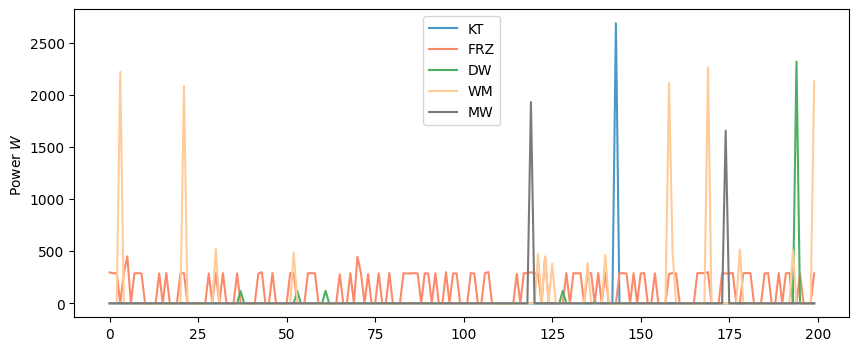

In [25]:
appliance_labels={'kettle':"KT", 'fridge':"FRZ", 'dish washer':"DW", 'washer dryer':"WM", 'microwave':"MW"}
fig = plt.figure(figsize=(10, 4))
for i, app in enumerate(list(appliance_data.keys())):
    plt.plot(y_t_unet[:,i]*z_t_unet[:,i], label=appliance_labels[app], color=colors[i])
    #plt.plot(y_p_unet[:,2,i]t label=appliance_labels[app], color=colors[i], linestyle="--")
plt.ylabel("Power $W$")
plt.legend()

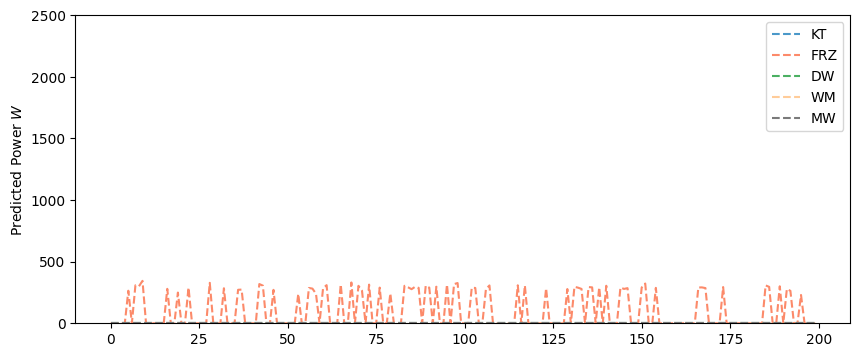

In [26]:
appliance_labels={'kettle':"KT", 'fridge':"FRZ", 'dish washer':"DW", 'washer dryer':"WM", 'microwave':"MW"}
fig = plt.figure(figsize=(10, 4))
for i, app in enumerate(list(appliance_data.keys())):
    # plt.plot(y_p_unet[:,2,i], label=appliance_labels[app], color=colors[i], linestyle="--")
    plt.plot(y_p_unet[:,2,i]*z_p_unet[:,i], label=appliance_labels[app], color=colors[i], linestyle="--")
plt.ylabel("Predicted Power $W$")
plt.ylim(0, 2500)
plt.legend()

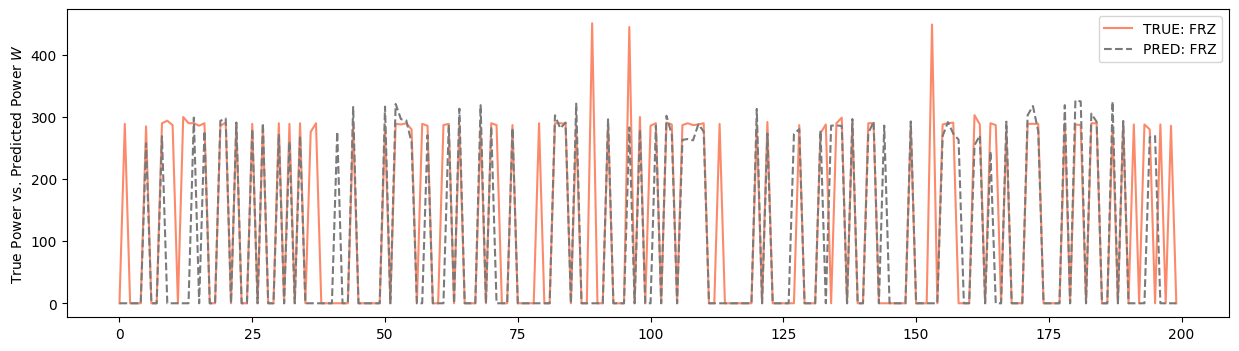

In [27]:
start = 79450
end = start + 200

y_p_unet = model_result['pred_power'][start:end]
y_t_unet = model_result['power'][start:end]
z_t_unet = model_result['state'][start:end]
z_p_unet = model_result['pred_state'][start:end]

colors =[plt.cm.Blues(0.6), plt.cm.Reds(0.4), plt.cm.Greens(0.6), '#ffcc99', plt.cm.Greys(0.6)]
i = 1
app = 'fridge'
fig = plt.figure(figsize=(15, 4))

plt.plot(y_t_unet[:,i]*z_t_unet[:,i], label=f"TRUE: {appliance_labels[app]}", color=colors[i])
plt.plot(y_p_unet[:,2,i]*z_p_unet[:,i], label=f"PRED: {appliance_labels[app]}", color=colors[-1], linestyle="--")
plt.ylabel("True Power vs. Predicted Power $W$")
plt.legend()